# 05. 벡터의 유사도(Vector Similarity)
- 문서들 간에 동일한 단어 또는 비슷한 단어가 얼마나 공통적으로 많이 사용되었는지

## 05-01 코사인 유사도(Cosine Similarity)

### 1. 코사인 유사도(Cosine Similarity)
- 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미
- 두 벡터의 방향이 완전히 동일한 경우에는 1
- 90°의 각을 이루면 0
- 180°로 반대의 방향을 가지면 -1
- 코사인 유사도는 -1 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단
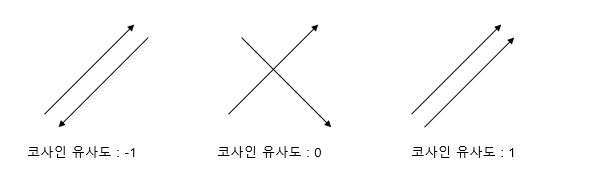
$$similarity=cos(Θ)=\frac{A⋅B}{||A||\ ||B||}=\frac{\sum_{i=1}^{n}{A_{i}×B_{i}}}{\sqrt{\sum_{i=1}^{n}(A_{i})^2}×\sqrt{\sum_{i=1}^{n}(B_{i})^2}}$$

#### 예시
>문서1 : 저는 사과 좋아요<br>
문서2 : 저는 바나나 좋아요<br>
문서3 : 저는 바나나 좋아요 저는 바나나 좋아요

||바나나|사과|저는|좋아요|
|--|--|--|--|--|
|문서1|0|1|1|1|
|문서2|1|0|1|1|
|문서3|1|0|2|2|

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

doc1 = np.array([0,1,1,1])
doc2 = np.array([1,0,1,1])
doc3 = np.array([2,0,2,2])

print('문서 1과 문서2의 유사도 :',cos_sim(doc1, doc2))
print('문서 1과 문서3의 유사도 :',cos_sim(doc1, doc3))
print('문서 2와 문서3의 유사도 :',cos_sim(doc2, doc3))

문서 1과 문서2의 유사도 : 0.6666666666666667
문서 1과 문서3의 유사도 : 0.6666666666666667
문서 2와 문서3의 유사도 : 1.0000000000000002


- 코사인 유사도는 유사도를 구할 때 벡터의 방향(패턴)에 초점을 두므로 코사인 유사도는 문서의 길이가 다른 상황에서 비교적 공정한 비교를 할 수 있도록 도와줍니다.

### 2. 유사도를 이용한 추천 시스템 구현하기
- 다운로드 링크 : https://www.kaggle.com/rounakbanik/the-movies-dataset
- 원본 파일은 위 링크에서 movies_metadata.csv 파일을 다운로드 
- 총 24개의 열을 가진 45,466개의 샘플

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

data = pd.read_csv('movies_metadata.csv', low_memory=False)
data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [3]:
# 상위 2만개의 샘플을 data에 저장
data = data.head(20000)

In [4]:
# overview 열에 존재하는 모든 결측값을 전부 카운트하여 출력
print('overview 열의 결측값의 수:',data['overview'].isnull().sum())

overview 열의 결측값의 수: 135


In [5]:
# 결측값을 빈 값으로 대체
data['overview'] = data['overview'].fillna('')

In [6]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['overview'])
print('TF-IDF 행렬의 크기(shape) :',tfidf_matrix.shape)

TF-IDF 행렬의 크기(shape) : (20000, 47487)


In [7]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print('코사인 유사도 연산 결과 :',cosine_sim.shape)

코사인 유사도 연산 결과 : (20000, 20000)


In [8]:
title_to_index = dict(zip(data['title'], data.index))

# 영화 제목 Father of the Bride Part II의 인덱스를 리턴
idx = title_to_index['Father of the Bride Part II']
print(idx)

4


In [9]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # 선택한 영화의 타이틀로부터 해당 영화의 인덱스를 받아온다.
    idx = title_to_index[title]

    # 해당 영화와 모든 영화와의 유사도를 가져온다.
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 유사도에 따라 영화들을 정렬한다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 10개의 영화를 받아온다.
    sim_scores = sim_scores[1:11]

    # 가장 유사한 10개의 영화의 인덱스를 얻는다.
    movie_indices = [idx[0] for idx in sim_scores]

    # 가장 유사한 10개의 영화의 제목을 리턴한다.
    return data['title'].iloc[movie_indices]

In [10]:
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object

- 가장 유사한 영화가 출력되는데, 영화 다크 나이트가 첫번째고, 그 외에도 전부 배트맨 영화를 찾아냄

## 05-02 여러가지 유사도 기법

### 1. 유클리드 거리(Euclidean distance)
- 유용하진 않지만 다른 개념들을 이해할 때 도움이 됨
- 다차원 공간에서 두개의 점  $p$와 $q$가 각각 $p=(p_{1}, p_{2}, p_{3}, ... , p_{n})$과 $q=(q_{1}, q_{2}, q_{3}, ..., q_{n})$의 좌표를 가질때
$$\sqrt{(q_{1}-p_{1})^{2}+(q_{2}-p_{2})^{2}+\ ...\ +(q_{n}-p_{n})^{2}}=\sqrt{\sum_{i=1}^{n}(q_{i}-p_{i})^{2}}$$

- 2차원 공간이라고 가정하고 두 점  사이의 거리를 시각화
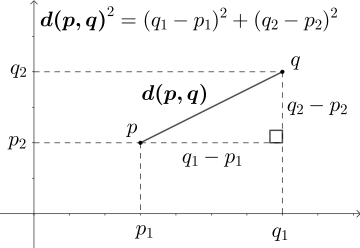
- 2차원 좌표 평면에서 두 점 사이의 유클리드 거리 공식은 피타고라스의 정리를 통해 두 점 사이의 거리를 구하는 것과 동일

#### 예시 DTM
||바나나|사과|저는|좋아요|
|--|--|--|--|--|
|문서1|2|3|0|1|
|문서2|1|2|3|1|
|문서3|2|1|2|2|
|문서Q|1|1|0|1|

- 유클리드 거리를 통해 문서Q과 나머지 문서1, 2, 3의 유사도를 구하려고 할때

In [11]:
import numpy as np

def dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))

doc1 = np.array((2,3,0,1))
doc2 = np.array((1,2,3,1))
doc3 = np.array((2,1,2,2))
docQ = np.array((1,1,0,1))

print('문서1과 문서Q의 거리 :',dist(doc1,docQ))
print('문서2과 문서Q의 거리 :',dist(doc2,docQ))
print('문서3과 문서Q의 거리 :',dist(doc3,docQ))

문서1과 문서Q의 거리 : 2.23606797749979
문서2과 문서Q의 거리 : 3.1622776601683795
문서3과 문서Q의 거리 : 2.449489742783178


- 유클리드 거리의 값이 가장 작다는 것은 문서 간 거리가 가장 가깝다를 의미
- 문서1이 문서Q와 가장 유사

### 2. 자카드 유사도(Jaccard similarity)
-  합집합에서 교집합의 비율을 구한다면 두 집합 A와 B의 유사도를 구할 수 있다
$$J(A,B)=\frac{|A∩B|}{|A∪B|}=\frac{|A∩B|}{|A|+|B|-|A∩B|}$$

In [12]:
doc1 = "apple banana everyone like likey watch card holder"
doc2 = "apple banana coupon passport love you"

# 토큰화
tokenized_doc1 = doc1.split()
tokenized_doc2 = doc2.split()

print('문서1 :',tokenized_doc1)
print('문서2 :',tokenized_doc2)

문서1 : ['apple', 'banana', 'everyone', 'like', 'likey', 'watch', 'card', 'holder']
문서2 : ['apple', 'banana', 'coupon', 'passport', 'love', 'you']


In [13]:
union = set(tokenized_doc1).union(set(tokenized_doc2))
print('문서1과 문서2의 합집합 :',union)

문서1과 문서2의 합집합 : {'likey', 'card', 'passport', 'love', 'holder', 'everyone', 'you', 'banana', 'apple', 'coupon', 'watch', 'like'}


In [14]:
intersection = set(tokenized_doc1).intersection(set(tokenized_doc2))
print('문서1과 문서2의 교집합 :',intersection)

문서1과 문서2의 교집합 : {'banana', 'apple'}


In [15]:
print('자카드 유사도 :',len(intersection)/len(union))

자카드 유사도 : 0.16666666666666666
